In [156]:
import os
import getpass
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage, ToolMessage
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableParallel, RunnableLambda, RunnableBranch
from langchain_core.tools import tool, StructuredTool
import yfinance as yf
import requests
from typing import Dict, Any, List, Optional
from langsmith import traceable
from tavily import TavilyClient
from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass, fields, field
import json
from typing_extensions import TypedDict, Annotated, Literal
import operator
from IPython.display import Markdown
from bs4 import BeautifulSoup
from urllib.request import urlopen
from enum import Enum
import os
import google.oauth2.credentials
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

In [157]:
load_dotenv()

True

In [158]:
llm = ChatGroq(model_name = 'Gemma2-9b-it', api_key = os.getenv('GROQ_API_KEY'))

## Prompt

In [159]:
query_writer_instruction_web = """Your goal is to generate a targeted web search query related to financial investments or any finance-related topic specified by the user.

<TOPIC>
{finance_topic}
</TOPIC>

<FORMAT>
Format your response as a JSON object with ALL three of these exact keys:
   - "query": The actual search query string
   - "aspect": The specific aspect of the finance topic being researched
   - "rationale": Brief explanation of why this query is relevant
</FORMAT>

<EXAMPLE>
Example output:
{{
    "query": "best index funds for long-term investment 2025",
    "aspect": "investment strategy",
    "rationale": "Identifying top-performing index funds for long-term portfolio growth"
}}
</EXAMPLE>

Provide your response in JSON format:
"""

summarizer_instruction_web = """<GOAL>
Generate a high-quality summary of the web search results, focusing on financial investments or the specific finance-related topic requested by the user.
</GOAL>

<REQUIREMENTS>
When creating a NEW summary:
1. Highlight the most relevant financial insights, trends, or strategies from the search results.
2. Ensure a coherent flow of information while keeping it concise and actionable.

When EXTENDING an existing summary:
1. Read the existing summary and new search results carefully.
2. Compare the new information with the existing summary.
3. For each piece of new information:
    a. If it builds on an existing point, integrate it smoothly.
    b. If it introduces a new relevant aspect, add a separate paragraph.
    c. If it’s irrelevant to financial investments, ignore it.
4. Ensure all additions align with the user’s finance-related query.
5. Verify that the final output differs from the original summary while improving its depth.

<FORMATTING>
- Start directly with the updated summary, without preamble or titles. Do not use XML tags in the output.
</FORMATTING>
"""

reflection_instructions_web = """You are an expert financial research assistant analyzing a summary about {finance_topic}.

<GOAL>
1. Identify missing details or areas that need deeper exploration.
2. Generate a follow-up question to help expand financial knowledge.
3. Focus on investment strategies, market trends, risk factors, regulations, or financial instruments that weren’t fully covered.
</GOAL>

<REQUIREMENTS>
Ensure the follow-up question is self-contained and provides necessary context for a web search.
</REQUIREMENTS>

<FORMAT>
Format your response as a JSON object with these exact keys:
- "knowledge_gap": Describe what financial information is missing or unclear.
- "follow_up_query": Write a specific question to address this gap.
</FORMAT>

<EXAMPLE>
Example output:
{{
    "knowledge_gap": "The summary does not mention tax implications of investing in ETFs vs. mutual funds.",
    "follow_up_query": "What are the tax advantages and disadvantages of ETFs compared to mutual funds?"
}}
</EXAMPLE>

Provide your analysis in JSON format:
"""


## States

In [160]:
class State(TypedDict):
    route: Literal['Web_query', 'Normal_query', 'Financial_Analysis'] = Field(None)
    research_topic: str = ""
    search_query: str = ""
    web_research_results: Annotated[list, operator.add] = []
    sources_gathered: Annotated[list, operator.add] = []
    research_loop_count: int = 0
    running_summary: str = ""
    messages: Annotated[list, operator.add] = []

In [161]:
def create_initial_state(user_query: str):
    return {
        "route": None,
        "research_topic": user_query,
        "search_query": "",
        "web_research_results": [],
        "sources_gathered": [],
        "research_loop_count": 0,
        "running_summary": "",
        "messages": [HumanMessage(content=user_query)]
    }

## First Routing Step

In [162]:
class Route_First_Step(BaseModel):
    step: Literal['Web_query', 'Normal_query', 'Financial_Analysis'] = Field(None, description = 'Given the query, determine whether to perform a web search, answer a normal question(like a definition), or perform a financial analysis(for which you have tools).')

In [163]:
class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the research assistant."""
    max_web_research_loops: int = int(os.environ.get("MAX_WEB_RESEARCH_LOOPS", "3"))
    #local_llm: str = llm
    search_api: SearchAPI = SearchAPI(os.environ.get("SEARCH_API", SearchAPI.TAVILY.value))  # Default to DUCKDUCKGO
    fetch_full_page: bool = os.environ.get("FETCH_FULL_PAGE", "False").lower() in ("true", "1", "t")
    ollama_base_url: str = os.environ.get("OLLAMA_BASE_URL", "http://localhost:11434/")

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

In [164]:
@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    """ Search the web using the Tavily API.

    Args:
        query (str): The search query to execute
        include_raw_content (bool): Whether to include the raw_content from Tavily in the formatted string
        max_results (int): Maximum number of results to return

    Returns:
        dict: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""

    api_key = os.environ['TAVILY_API_KEY']
    if not api_key:
        raise ValueError("TAVILY_API_KEY environment variable is not set")
    tavily_client = TavilyClient(api_key=api_key)
    return tavily_client.search(query,
                         max_results=max_results,
                         include_raw_content=include_raw_content)

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=False):
    """
    Takes either a single search response or list of responses from search APIs and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()

def format_sources(search_results):
    """Format search results into a bullet-point list of sources.

    Args:
        search_results (dict): Tavily search response containing results

    Returns:
        str: Formatted string with sources and their URLs
    """
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

def generate_query(state: State, config: RunnableConfig):
    """Generate a query for web search."""
    # Format the prompt using the correct placeholder
    query_writer_instruction_web_formatted = query_writer_instruction_web.format(finance_topic=state["research_topic"])
    prompt = query_writer_instruction_web_formatted + "\nGenerate a query for web search:"

    result = llm.invoke(prompt)
    output_text = result.content.strip()
# In generate_query function:
    try:
        query_data = json.loads(output_text)
        return {"search_query": query_data['query']}
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON: {e}")
        return {"search_query": f"comprehensive analysis of {state['research_topic']}"}

def web_research(state: State, config: RunnableConfig):
    """Gather information from the web."""
    configurable = Configuration.from_runnable_config(config)

    # Determine which search API to use
    if isinstance(configurable.search_api, str):
        search_api = configurable.search_api
    else:
        search_api = configurable.search_api.value

    if search_api == "tavily":
        search_results = tavily_search(state["search_query"], include_raw_content=True, max_results=1)
        search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=True)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")

    return {
        "sources_gathered": [format_sources(search_results)],
        "research_loop_count": state["research_loop_count"] + 1,
        "web_research_results": [search_str]
    }


def summarize_sources(state: State, config: RunnableConfig):
    """Summarize the gathered sources."""
    # Existing summary and most recent search results
    existing_summary = state['running_summary']
    most_recent_web_research = state['web_research_results'][-1]

    if existing_summary:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Search Results> \n {most_recent_web_research} \n <New Search Results>"
        )
    else:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Search Results> \n {most_recent_web_research} \n <Search Results>"
        )

    prompt = summarizer_instruction_web + "\n" + human_message_content

    result = llm.invoke(prompt)
    running_summary = result.content

    # Remove any unwanted <think> tags
    while "<think>" in running_summary and "</think>" in running_summary:
        start = running_summary.find("<think>")
        end = running_summary.find("</think>") + len("</think>")
        running_summary = running_summary[:start] + running_summary[end:]

    return {"running_summary": running_summary}

def reflect_on_summary(state: State, config: RunnableConfig):
    """Reflect on the summary and generate a follow-up query."""
    prompt = (
        reflection_instructions_web.format(finance_topic=state['research_topic'])
        + "\nIdentify a knowledge gap and generate a follow-up web search query based on our existing knowledge: "
        + state['running_summary']
    )

    result = llm.invoke(prompt)
    
    output_text = result.content.strip()
    try:
        follow_up_query = json.loads(output_text)
    except json.JSONDecodeError:
        print("Error: Could not decode JSON from reflect_on_summary. Response was:", output_text)
        # Fallback: Return a default follow-up query
        follow_up_query = {"follow_up_query": f"Tell me more about {state['research_topic']}"}

    query = follow_up_query.get('follow_up_query')
    if not query:
        return {"search_query": f"Tell me more about {state['research_topic']}"}
    return {"search_query": query}


def finalize_summary(state: State):
    """Finalize the summary by aggregating all source information."""
    all_sources = "\n".join(source for source in state['sources_gathered'])
    final_summary = f"## Web Research Summary\n\n{state['running_summary']}\n\n### Sources:\n{all_sources}"
    
    # Create a consistent message output
    final_message = HumanMessage(content=final_summary)
    
    return {
        "running_summary": final_summary,
        "messages": [final_message]
    }

def route_research(state: State, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    configurable = Configuration.from_runnable_config(config)
    if state['research_loop_count'] < configurable.max_web_research_loops:  # Changed to <
        return "web_research"
    return "finalize_summary"

In [165]:
router = llm.with_structured_output(Route_First_Step)

In [166]:
def call_route_first_step(state: State):
    
    # Make the routing decision
    decision = router.invoke(state["research_topic"])
    
    # Update the state with the route and research_topic
    return {
        "route": decision.step,
    }

In [167]:
def validate_state_transition(old_state: State, new_state: State):
    required_fields = set(State.__annotations__.keys())
    missing = required_fields - set(new_state.keys())
    if missing:
        raise ValueError(f"Missing state updates for: {missing}")
    return True

In [188]:
from langchain_core.tools import tool, StructuredTool
import yfinance as yf



@tool
def company_address(ticker: str) -> str:
    """
    Returns company address for input ticker.
    e.g. company_address: AAPL
    Returns company address for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return " ".join([info[key] for key in ['address1','city','state','zip','country']])

@tool
def fulltime_employees(ticker: str) -> int:
    """
    Returns fulltime employees count for input ticker.
    e.g. company_address: MSFT
    Returns fulltime employees count for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['fullTimeEmployees']

@tool
def last_close_price(ticker: str) -> float:
    """
    Returns last close price for input ticker.
    e.g. company_address: MSFT
    Returns last close price for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['previousClose']

@tool
def EBITDA(ticker: str) -> float:
    """
    Returns EBITDA for input ticker.
    e.g. company_address: AAPL
    Returns EBITDA for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['ebitda']

@tool
def total_debt(ticker: str) -> float:
    """
    Returns total debt for input ticker.
    e.g. company_address: AAPL
    Returns total debt for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalDebt']

@tool
def total_revenue(ticker: str) -> float:
    """
    Returns total revenue for input ticker.
    e.g. company_address: MSFT
    Returns total revenue for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalRevenue']

@tool
def debt_to_equity_ratio(ticker: str) -> float:
    """
    Returns debt to equity ratio for input ticker.
    e.g. company_address: AAPL
    Returns debt to equity ratio for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['debtToEquity']

finance_tools = [
    company_address,
    fulltime_employees,
    last_close_price,
    EBITDA,
    total_debt,
    total_revenue,
    debt_to_equity_ratio
]

finance_tool_map = {t.name: t for t in finance_tools}

In [189]:
llm_normal = llm
normal_query_prompt = """
You are a financial analyst. Please answer the user's question based on what you know, don't make up anything.
"""


In [201]:
def answer_normal_query(state: State):
    # Get the messages from the state
    messages = state.get('messages', [])
    # Add system message with Markdown instruction
    system_message = SystemMessage(content=normal_query_prompt + "\nFormat your response in Markdown.")
    # Invoke LLM with both system and user messages
    response = llm_normal.invoke([system_message] + messages)
    
    # Create a consistent message output
    markdown_response = f"## Normal Query Response\n\n{response.content}"
    
    # Return both the formatted markdown and the messages
    return {
        "running_summary": markdown_response,
        "messages": [HumanMessage(content=markdown_response)]
    }

In [191]:
llm_financial_analysis = llm.bind_tools(finance_tools, tool_choice = 'auto')
financial_analysis_prompt = """
You are a financial analyst. You are given tools for acurate data
"""


In [ ]:
def format_tool_results_markdown(tool_results):
    markdown_output = "## Financial Analysis Results\n\n"
    for result in tool_results:
        tool_name = result.name
        content = result.content
        markdown_output += f"### {tool_name.replace('_', ' ').title()}\n\n{content}\n\n"
    return markdown_output

In [192]:
def call_llm(state: State):
    messages = state['messages']
    
    system_prompt = financial_analysis_prompt + "\nFormat your response in Markdown."
    messages = [SystemMessage(content=system_prompt)] + messages
    
    # Invoke the LLM
    message = llm_financial_analysis.invoke(messages)
    return {'messages': [message]}


def exists_action(state: State):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

def take_action(state: State):
    tool_calls = state['messages'][-1].tool_calls
    tool_results = []
    
    for t in tool_calls:
        try:
            tool_func = finance_tool_map[t['name']]
            result = tool_func.invoke(t['args'])
        except KeyError:
            result = f"Error: Tool {t['name']} not found"
        except Exception as e:
            result = f"Error executing tool: {str(e)}"
        
        tool_results.append(ToolMessage(
            tool_call_id=t['id'],
            name=t['name'],
            content=str(result)
        ))
    
    # Format the results in Markdown
    markdown_output = format_tool_results_markdown(tool_results)
    
    # Update the state with both the tool results and the markdown output
    return {
        'messages': tool_results,
        'running_summary': markdown_output
    }

In [203]:
def format_financial_analysis(state: State):
    messages = state['messages']
    tool_results = [msg for msg in messages if isinstance(msg, ToolMessage)]
    
    # If there are tool results, format them
    if tool_results:
        markdown_output = format_tool_results_markdown(tool_results)
    else:
        # If no tool results, just use the last message
        markdown_output = f"## Financial Analysis\n\n{messages[-1].content}"
    
    return {
        "running_summary": markdown_output,
        "messages": [HumanMessage(content=markdown_output)]
    }

## Final Route Builder

In [193]:
def get_route(state: State) -> str:
    return state["route"]


In [204]:
def update_router():
    final_router = StateGraph(State)
    final_router.add_node("route_first_step", call_route_first_step)
    final_router.add_node("generate_query", generate_query)
    final_router.add_node("web_research", web_research)
    final_router.add_node("summarize_sources", summarize_sources)
    final_router.add_node("reflect_on_summary", reflect_on_summary)
    final_router.add_node("finalize_summary", finalize_summary)
    final_router.add_node('call_llm', call_llm)
    final_router.add_node('take_action', take_action)
    final_router.add_node('format_financial_analysis', format_financial_analysis)
    final_router.add_node('answer_normal_query', answer_normal_query)
    
    final_router.add_edge(START, "route_first_step")
    final_router.add_conditional_edges("route_first_step", get_route, {
        'Web_query': 'generate_query',
        'Normal_query': 'answer_normal_query',
        'Financial_Analysis': 'call_llm'
    })
    
    final_router.add_edge("answer_normal_query", END)
    
    final_router.add_conditional_edges(
        "call_llm",
        exists_action,
        {True: "take_action", False: "format_financial_analysis"}
    )
    final_router.add_edge("take_action", "format_financial_analysis")
    final_router.add_edge("format_financial_analysis", END)
    
    final_router.add_edge("generate_query", "web_research")
    final_router.add_edge("web_research", "summarize_sources")
    final_router.add_edge("summarize_sources", "reflect_on_summary")
    final_router.add_conditional_edges("reflect_on_summary", route_research)
    final_router.add_edge("finalize_summary", END)
    
    return final_router.compile()


In [238]:
final_model = update_router()

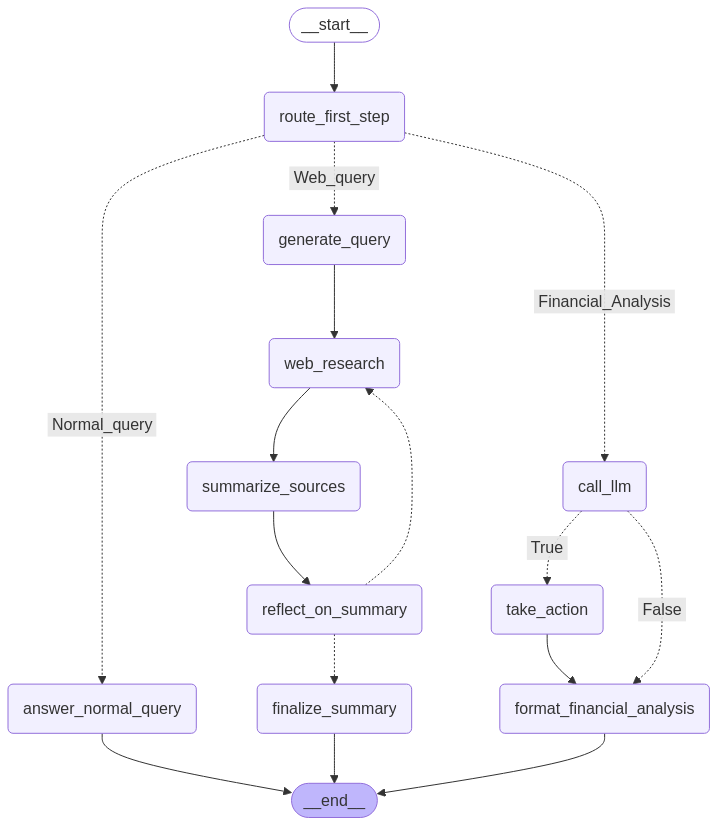

In [239]:
display(Image(final_model.get_graph().draw_mermaid_png()))

In [208]:
initial_state = {
    "query": "What does stock mean?",
    "route": None,
    "research_topic": "What does stock mean?",
    "search_query": "What does stock mean?",
    "web_research_results": [],
    "sources_gathered": [],
    "research_loop_count": 0,
    "running_summary": "",
    "message": []
}
normal_query = final_model.invoke(initial_state)


In [221]:
if __name__ == "__main__":
    # Initialize with proper state structure
    initial_state = create_initial_state("What is the latest news about Reliance Industries?")
    
    # Execute workflow
    result = final_model.invoke(initial_state)
    
    # Validate final state
    validate_state_transition(initial_state, result)
    print("Final state validated successfully!")
    print("Summary:", result["running_summary"])

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
Error: Could not decode JSON from reflect_on_summary. Response was: ```json
{
    "knowledge_gap": "While the summary highlights analyst optimism and potential catalysts, it lacks specific details about Reliance Industries' financial performance, such as recent earnings reports, revenue growth, or profitability metrics.  ",
    "follow_up_query": "What are Reliance Industries' latest quarterly earnings reports and key financial performance indicators?"
}
```
Error: Could not decode JSON from reflect_on_summary. Response was: ```json
{
    "knowledge_gap": "While the summary mentions analyst upgrades and target prices for Reliance Industries, it doesn't delve into the specific financial metrics or ratios driving these positive assessments.  Understanding these underlying factors would provide a more comprehensive view of the investment thesis.",
    "follow_up_query": "What are the key financial metrics and ratios that analys

In [222]:
result

{'route': 'Web_query',
 'research_topic': 'What is the latest news about Reliance Industries?',
 'search_query': 'Tell me more about What is the latest news about Reliance Industries?',
 'web_research_results': ["Sources:\n\nSource Reliance Industries Gain Momentum As Brokerages Project Positive ...:\n===\nURL: https://www.timesnownews.com/business-economy/companies/reliance-industries-gain-momentum-as-brokerages-project-positive-perfomance-with-upgraded-target-price-article-118838825\n===\nMost relevant content from source: Reliance Industries' stock has garnered positive attention from leading brokerages, reversing its recent downturn. With upgrades from Macquarie, Morgan Stanley, and Kotak Institutional Equities, analysts foresee significant growth catalysts, including better earnings momentum and a potential Jio listing., Companies News - Times Now\n===\nFull source content limited to 1000 tokens: Theme\n\nBusiness\n\nPersonal Finance\n\nMarkets\n\nCompanies\n\nEconomy\n\nIndustry\

In [223]:
result['messages'][-1].content

"## Summary\n\nReliance Industries continues to see positive momentum, with analysts maintaining optimistic outlooks.  Motilal Oswal Financial Services recently recommended buying Reliance Industries shares, setting a target price of Rs 1,605.  \n\nThis positive sentiment is supported by a surge in the market valuation of the top-10 most valued firms, including Reliance, which saw a combined increase of Rs 1,18,151.75 crore last week. HDFC Bank and Bharti Airtel were the biggest gainers among these companies, highlighting a broader positive trend in the equities market. \n\nReliance Retail's re-launch of Shein in India has sparked a competitive landscape in the fast fashion sector, challenging established players like Trent's Zudio and Nykaa Fashion. While Shein's online-first model presents a formidable challenge, experts note potential hurdles for the company in establishing its supply chain and achieving profitable unit economics. \n\n\n\n\n### Sources:\n* Reliance Industries Gain M

In [224]:
Markdown(result['messages'][-1].content)

## Summary

Reliance Industries continues to see positive momentum, with analysts maintaining optimistic outlooks.  Motilal Oswal Financial Services recently recommended buying Reliance Industries shares, setting a target price of Rs 1,605.  

This positive sentiment is supported by a surge in the market valuation of the top-10 most valued firms, including Reliance, which saw a combined increase of Rs 1,18,151.75 crore last week. HDFC Bank and Bharti Airtel were the biggest gainers among these companies, highlighting a broader positive trend in the equities market. 

Reliance Retail's re-launch of Shein in India has sparked a competitive landscape in the fast fashion sector, challenging established players like Trent's Zudio and Nykaa Fashion. While Shein's online-first model presents a formidable challenge, experts note potential hurdles for the company in establishing its supply chain and achieving profitable unit economics. 




### Sources:
* Reliance Industries Gain Momentum As Brokerages Project Positive ... : https://www.timesnownews.com/business-economy/companies/reliance-industries-gain-momentum-as-brokerages-project-positive-perfomance-with-upgraded-target-price-article-118838825
* Reliance Industries News - Reliance Industries Announcement, Latest ... : https://economictimes.indiatimes.com/reliance-industries-ltd/stocksupdate/companyid-13215.cms
* Reliance Industries News - Reliance Industries Announcement, Latest ... : https://economictimes.indiatimes.com/reliance-industries-ltd/stocksupdate/companyid-13215.cms

In [235]:
pip install google-auth-oauthlib

Note: you may need to restart the kernel to use updated packages.


In [243]:


class YouTubeVideoRecommender:
    def __init__(self, api_key):
        """
        Initialize the YouTube API client.
        
        Args:
            api_key (str): Your YouTube Data API key
        """
        self.api_key = api_key
        self.youtube = googleapiclient.discovery.build(
            "youtube", "v3", developerKey=api_key)
    
    def get_channel_id(self, channel_name):
        """
        Get the channel ID for a given channel name.
        
        Args:
            channel_name (str): The name of the YouTube channel
            
        Returns:
            str: The channel ID or None if not found
        """
        request = self.youtube.search().list(
            part="snippet",
            q=channel_name,
            type="channel",
            maxResults=1
        )
        response = request.execute()
        
        if response['items']:
            return response['items'][0]['id']['channelId']
        return None
    
    def search_videos_in_channel(self, channel_id, query, max_results=10):
        """
        Search for videos matching a query within a specific channel.
        
        Args:
            channel_id (str): The ID of the YouTube channel
            query (str): The search query
            max_results (int): Maximum number of videos to retrieve
            
        Returns:
            list: List of video information dictionaries
        """
        request = self.youtube.search().list(
            part="snippet",
            channelId=channel_id,
            q=query,
            type="video",
            maxResults=max_results
        )
        response = request.execute()
        
        videos = []
        for item in response['items']:
            video_id = item['id']['videoId']
            title = item['snippet']['title']
            description = item['snippet']['description']
            published_at = item['snippet']['publishedAt']
            thumbnail = item['snippet']['thumbnails']['high']['url']
            channel_title = item['snippet']['channelTitle']
            
            videos.append({
                'video_id': video_id,
                'title': title,
                'description': description,
                'published_at': published_at,
                'thumbnail': thumbnail,
                'channel': channel_title,
                'url': f"https://www.youtube.com/watch?v={video_id}"
            })
        
        return videos

    def recommend_videos(self, query, channels, videos_per_channel=5):
        """
        Recommend videos from specified channels based on user query.
        
        Args:
            query (str): User's search query
            channels (list): List of channel names or IDs to search within
            videos_per_channel (int): Maximum number of videos per channel
            
        Returns:
            list: Combined list of relevant videos from all channels
        """
        all_videos = []
        
        for channel in channels:
            # Check if the input is a channel ID or name
            if channel.startswith('UC') and len(channel) == 24:
                channel_id = channel
            else:
                channel_id = self.get_channel_id(channel)
                if not channel_id:
                    print(f"Could not find channel: {channel}")
                    continue
            
            # Search for videos matching the query in this channel
            videos = self.search_videos_in_channel(channel_id, query, videos_per_channel)
            all_videos.extend(videos)
        
        # Sort by relevance (already done by API, but can be customized)
        return all_videos

def main():
    """
    Main function to run the YouTube video recommender.
    """
    # Replace with your actual API key
    # Initialize the recommender
    recommender = YouTubeVideoRecommender(api_key= os.getenv('YOUTUBE_API_KEY'))
    
    # List of channels to include in recommendations
    # Can be channel names or channel IDs (starting with 'UC')
    favorite_channels = [
    "ZEE Business",  # Example: freeCodeCamp
    "Economic Times",  # Example: Corey Schafer
    "Times Now",
    "Times Now Business",
    "Times Now News",
    "Times Now Politics",
    "Times Now Sports",
    "Times Now Science",
    "Times Now Technology",
    'Pranjal Kamra',
    'Yadnya Investment Academy',
    'CA Rachana Phadke Ranade',
    'Invest Aaj For Kal',
    'Market Gurukul',
    'Warikoo',
    'Asset Yogi',
    'Trading Chanakya',
    'Trade Brains',
    'B Wealthy',
    'Capital Pritika',
    'The Urban Fight',
    'Kritika Yadav',
    'Gurleen Kaur Tikku'
]
    # Get user query
    user_query = input("What type of videos are you interested in? ")
    
    # Get recommendations
    recommendations = recommender.recommend_videos(
        query=user_query,
        channels=favorite_channels,
        videos_per_channel=1
    )
    
    # Display recommendations
    print(f"\nRecommended videos for '{user_query}' from your favorite channels:")
    if not recommendations:
        print("No matching videos found in your selected channels.")
    else:
        for i, video in enumerate(recommendations, 1):
            print(f"\n{i}. {video['title']}")
            print(f"   Channel: {video['channel']}")
            print(f"   URL: {video['url']}")
            print(f"   Published: {video['published_at']}")

if __name__ == "__main__":
    main()

HttpError: <HttpError 403 when requesting https://youtube.googleapis.com/youtube/v3/search?part=snippet&q=ZEE+Business&type=channel&maxResults=1&alt=json returned "Request had insufficient authentication scopes.". Details: "[{'message': 'Insufficient Permission', 'domain': 'global', 'reason': 'insufficientPermissions'}]">